## PHASE 1: Preprocessing data from the RAVDESS dataset

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("C:/Users/Varun Mutalik Desai/Desktop/AI Club/data/processed/metadata.csv")

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["emotion"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["emotion"],
    random_state=42
)

In [117]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

sr = 22050

def preprocessing(y, sr):
    print(len(y)/sr)
    y_trimmed, intervals = librosa.effects.trim(
        y,
        top_db=30
    )

    if len(y_trimmed/sr) <= 0.2:
        return y
    else:
        y_norm = librosa.util.normalize(y_trimmed)
        print(len(y_norm)/sr)

        return y_norm



In [118]:
def augment_data(y, sr):
    if np.random.rand() < 0.5:
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2,2))
    if np.random.rand() < 0.5:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8,1.2))
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 0.005, len(y))
        y = y + noise
    return y


def fix_mel_shape(mel, max_frames=174):
    if mel.shape[1] < max_frames:
        pad_width = max_frames - mel.shape[1]
        mel = np.pad(mel, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mel = mel[:, :max_frames]
    return mel


In [119]:
import math

n_fft = 2048 #Fast Fourier Transform Component (higher means better distinguishability of freq but poor time res)
hop_length = n_fft//4 #gives a smoother spectogram
n_mels = 128
max_samples = 3 * sr
max_frames = math.ceil(max_samples / hop_length)

In [ ]:
def process_file(path, sr=22050, augment=False):
    #Load audio
    y, sr = librosa.load(path, sr=sr)

    #Trim + normalize
    y = preprocessing(y, sr)

    #Augment
    if augment:
        y = augment_data(y, sr)

    #pad / cut to fixed length
    if len(y) < max_samples:
    #padding the waveform
        pad_amount = max_samples - len(y)
        pad_width = (0, pad_amount)
        y = np.pad(y, pad_width, mode='constant', constant_values=0)
    elif len(y) > max_samples:
        #cutting the waveform
        if len(y) > max_samples:
            start = np.random.randint(0, len(y) - max_samples)
            y = y[start:start+max_samples]


    #Log-Mel
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    mel = fix_mel_shape(mel, max_frames=max_frames)

    log_mel = librosa.power_to_db(mel, ref=np.max)

    log_mel = (log_mel + 80) / 80

    return log_mel



## PHASE 2: Model Training & Evaluation

In [121]:
emotion_map = {
    "neutral": 0,
    "calm": 1,
    "happy": 2,
    "sad": 3,
    "angry": 4,
    "fearful": 5,
    "disgust": 6,
    "surprised": 7
}

In [ ]:
import os
import tensorflow as tf

PROCESSED_DIR = "C:/Users/Varun Mutalik Desai/Desktop/AI Club/data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

X_TRAIN_PATH = f"{PROCESSED_DIR}/X_train.npy"
y_TRAIN_EMOTION_PATH = f"{PROCESSED_DIR}/y_train_emotion.npy"
y_TRAIN_GENDER_PATH = f"{PROCESSED_DIR}/y_train_gender.npy"

X_VAL_PATH = f"{PROCESSED_DIR}/X_val.npy"
y_VAL_EMOTION_PATH = f"{PROCESSED_DIR}/y_val_emotion.npy"
y_VAL_GENDER_PATH = f"{PROCESSED_DIR}/y_val_gender.npy"

X_TEST_PATH = f"{PROCESSED_DIR}/X_test.npy"
y_TEST_EMOTION_PATH = f"{PROCESSED_DIR}/y_test_emotion.npy"
y_TEST_GENDER_PATH = f"{PROCESSED_DIR}/y_test_gender.npy"

features_exist = all([
    os.path.exists(X_TRAIN_PATH),
    os.path.exists(y_TRAIN_EMOTION_PATH),
    os.path.exists(y_TRAIN_GENDER_PATH),
    os.path.exists(X_VAL_PATH),
    os.path.exists(y_VAL_EMOTION_PATH),
    os.path.exists(y_VAL_GENDER_PATH),
    os.path.exists(X_TEST_PATH),
    os.path.exists(y_TEST_EMOTION_PATH),
    os.path.exists(y_TEST_GENDER_PATH),
])

if features_exist:

    X_train = np.load(X_TRAIN_PATH, allow_pickle=True)
    y_train_emotion = np.load(y_TRAIN_EMOTION_PATH, allow_pickle=True)
    y_train_gender = np.load(y_TRAIN_GENDER_PATH, allow_pickle=True)


    X_val = np.load(X_VAL_PATH, allow_pickle=True)
    y_val_emotion = np.load(y_VAL_EMOTION_PATH, allow_pickle=True)
    y_val_gender = np.load(y_VAL_GENDER_PATH, allow_pickle=True)

    X_test = np.load(X_TEST_PATH, allow_pickle=True)
    y_test_emotion = np.load(y_TEST_EMOTION_PATH, allow_pickle=True)
    y_test_gender = np.load(y_TEST_GENDER_PATH, allow_pickle=True)

else:

    X_train, y_train_emotion, y_train_gender = [], [], []

    for _, row in train_df.iterrows():

        mel = process_file(row["path"], augment=True)

        X_train.append(mel)
        y_train_emotion.append(emotion_map[row["emotion"]])
        y_train_gender.append(1 if row["gender"] == "male" else 0)

    X_train = np.stack(X_train)[..., np.newaxis]

    X_val, y_val_emotion, y_val_gender = [], [], []

    for _, row in val_df.iterrows():

        mel = process_file(row["path"], augment=False)

        X_val.append(mel)
        y_val_emotion.append(emotion_map[row["emotion"]])
        y_val_gender.append(1 if row["gender"] == "male" else 0)

    X_val = np.stack(X_val)[..., np.newaxis]

    X_test, y_test_emotion, y_test_gender = [], [], []

    for _, row in test_df.iterrows():

        mel = process_file(row["path"], augment=False)

        X_test.append(mel)
        y_test_emotion.append(emotion_map[row["emotion"]])
        y_test_gender.append(1 if row["gender"] == "male" else 0)

    X_test = np.stack(X_test)[..., np.newaxis]

    from tensorflow.keras.utils import to_categorical

    y_train_emotion = to_categorical(y_train_emotion, 8)
    y_val_emotion   = to_categorical(y_val_emotion, 8)
    y_test_emotion  = to_categorical(y_test_emotion, 8)

    y_train_gender = np.stack(y_train_gender)
    y_val_gender   = np.stack(y_val_gender)
    y_test_gender  = np.stack(y_test_gender)


    np.save(X_TRAIN_PATH, X_train)
    np.save(y_TRAIN_EMOTION_PATH, y_train_emotion)
    np.save(y_TRAIN_GENDER_PATH, y_train_gender)

    np.save(X_VAL_PATH, X_val)
    np.save(y_VAL_EMOTION_PATH, y_val_emotion)
    np.save(y_VAL_GENDER_PATH, y_val_gender)

    np.save(X_TEST_PATH, X_test)
    np.save(y_TEST_EMOTION_PATH, y_test_emotion)
    np.save(y_TEST_GENDER_PATH, y_test_gender)

X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print(X_train.shape)


X_train = np.squeeze(X_train, axis=-1)
X_val   = np.squeeze(X_val, axis=-1)
X_test  = np.squeeze(X_test, axis=-1)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

print(X_train.shape)
print(y_train_emotion.shape)
print(y_train_gender.shape)

y_train_emotion = y_train_emotion.astype("float32")
y_val_emotion = y_val_emotion.astype("float32")

y_train_gender = y_train_gender.astype("float32")
y_val_gender = y_val_gender.astype("float32")

print(np.bincount(np.argmax(y_train_emotion, axis=1)))
print(X_train.min(), X_train.max(), X_train.mean())


def focal_loss(gamma=2., alpha=.25):
    def loss(y_true_emotion, y_pred_emotion):
        ce = tf.keras.losses.categorical_crossentropy(y_true_emotion, y_pred_emotion)
        pt = tf.exp(-ce)
        return alpha * (1 - pt) ** gamma * ce
    return loss


(1152, 128, 130, 1, 1)
Train shape: (1152, 128, 130, 1)
Val shape: (144, 128, 130, 1)
Test shape: (144, 128, 130, 1)
(1152, 128, 130, 1)
(1152, 8)
(1152,)
[ 77 154 153 154 154 153 154 153]
0.0 1.0 0.25790562711322124


In [ ]:
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]

inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

emotion_output = layers.Dense(8, activation='softmax', name="emotion_output")(x)
gender_output = layers.Dense(1, activation='sigmoid', name="gender_output")(x)

model = models.Model(inputs=inputs, outputs=[emotion_output, gender_output])

print(X_train.shape)
print(y_train_emotion.shape)
print(y_train_gender.shape)
idx = 10
print(np.argmax(y_train_emotion[idx]), y_train_gender[idx])



(1152, 128, 130, 1)
(1152, 8)
(1152,)
7 0.0


In [124]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

emotion_labels = np.argmax(y_train_emotion, axis=1)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(emotion_labels),
    y=emotion_labels
)

class_weights_dict = dict(enumerate(class_weights))

# Gender and emotion we keep equal weight
emotion_sample_weights = np.ones(len(y_train_emotion))
gender_sample_weights = np.ones(len(y_train_gender))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)



In [125]:
tf.keras.backend.clear_session()

print(y_train_emotion[:5])
print(y_train_gender[:5])


model.compile(
    optimizer='adam',
    loss={
        "emotion_output": focal_loss(),
        "gender_output": "binary_crossentropy"
    },
    loss_weights={
        "emotion_output": 2.0,
        "gender_output": 0.5
    },
    metrics={
        "emotion_output": ["accuracy"],
        "gender_output": ["accuracy"]
    }
)

history = model.fit(
    X_train,
    [y_train_emotion, y_train_gender],
    validation_data=(X_val, [y_val_emotion, y_val_gender]),
    epochs=30,
    batch_size=32,
    sample_weight=[emotion_sample_weights, gender_sample_weights]
)

model.save("C:/Users/Varun Mutalik Desai/Desktop/AI Club/src/ser_model.keras")


[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
[0. 1. 1. 1. 0.]
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - emotion_output_accuracy: 0.2248 - emotion_output_loss: 0.3685 - gender_output_accuracy: 0.6875 - gender_output_loss: 0.5872 - loss: 1.0305 - val_emotion_output_accuracy: 0.1319 - val_emotion_output_loss: 0.4059 - val_gender_output_accuracy: 0.5972 - val_gender_output_loss: 0.6781 - val_loss: 1.1585
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - emotion_output_accuracy: 0.3160 - emotion_output_loss: 0.3251 - gender_output_accuracy: 0.8203 - gender_output_loss: 0.4384 - loss: 0.8694 - val_emotion_output_accuracy: 0.1319 - val_emotion_output_loss: 0.4641 - val_gender_output_accuracy: 0.5972 - val_gender_output_loss: 0.8238 - val_loss: 1.3594
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - emotion_output_accuracy: 0.3342 - emotion_output_loss: 0.3069 - gender_output_accura

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 130,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 62,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 62,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 31,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 29,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 29,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 8)         │      1,032 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,829 (1.27 MB)

 Trainable params: 110,793 (432.79 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 221,588 (865.58 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
[18 12  9 59  4 23  7 12]
[0 1 2 3 4 5 6 7] [0 1 2 3 4 5 6 7]


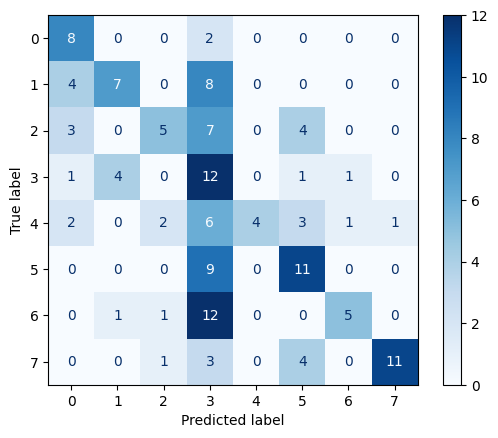

Macro F1: 0.455202929674129
Male F1: 0.39958798823128094
Female F1: 0.47942942942942945
Train emotion shape: (1152, 8)
Val emotion shape: (144, 8)
Test emotion shape: (144, 8)
Model outputs: ListWrapper(['emotion_output', 'gender_output'])
[ 77. 154. 153. 154. 154. 153. 154. 153.]


In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

model.summary()
pred_emotion, pred_gender = model.predict(X_test)
y_pred_emotion = np.argmax(pred_emotion, axis=1)
y_true_emotion = np.argmax(y_test_emotion, axis=1)

print(np.bincount(np.argmax(pred_emotion, axis=1)))

cm = confusion_matrix(y_true_emotion, y_pred_emotion)

print(np.unique(np.argmax(y_train_emotion, axis=1)),
np.unique(np.argmax(y_test_emotion, axis=1)))

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.show()

macro_f1 = f1_score(y_true_emotion, y_pred_emotion, average="macro")
print("Macro F1:", macro_f1)

male_indices = np.where(y_test_gender == 1)[0]
female_indices = np.where(y_test_gender == 0)[0]

male_f1 = f1_score(
    y_true_emotion[male_indices],
    y_pred_emotion[male_indices],
    average="macro"
)

female_f1 = f1_score(
    y_true_emotion[female_indices],
    y_pred_emotion[female_indices],
    average="macro"
)

print("Male F1:", male_f1)
print("Female F1:", female_f1)

print("Train emotion shape:", y_train_emotion.shape)
print("Val emotion shape:", y_val_emotion.shape)
print("Test emotion shape:", y_test_emotion.shape)
print("Model outputs:", model.output_names)
print(np.sum(y_train_emotion, axis=0))

